# Linear Regression with Regularization

This notebook implements linear regression with L1 (Lasso) and L2 (Ridge) regularization from scratch using NumPy.

## Mathematical Foundation

### Standard Linear Regression Cost Function
$$J(w,b) = \frac{1}{2m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2$$

### Ridge Regression (L2 Regularization)
$$J_{ridge}(w,b) = \frac{1}{2m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum_{j=1}^n w_j^2$$

### Lasso Regression (L1 Regularization)
$$J_{lasso}(w,b) = \frac{1}{2m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum_{j=1}^n |w_j|$$

### Elastic Net (L1 + L2)
$$J_{elastic}(w,b) = \frac{1}{2m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2 + \lambda_1 \sum_{j=1}^n |w_j| + \lambda_2 \sum_{j=1}^n w_j^2$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("📚 Linear Regression with Regularization")
print("Implementing Ridge, Lasso, and Elastic Net from scratch")

📚 Linear Regression with Regularization
Implementing Ridge, Lasso, and Elastic Net from scratch


## Data Loading

We'll use the same house prices dataset from the multiple variable linear regression notebook to demonstrate regularization.

Dataset shape: (1000, 4)
Features shape: (1000, 3)
Target shape: (1000,)

First 5 rows:
     size_sqft  bedrooms  age_years          price
0  2248.357077         4         42  482622.779930
1  1930.867849         1         18  304397.806645
2  2323.844269         3          4  457008.335401
3  2761.514928         5         10  605122.255898
4  1882.923313         3         11  429719.602090


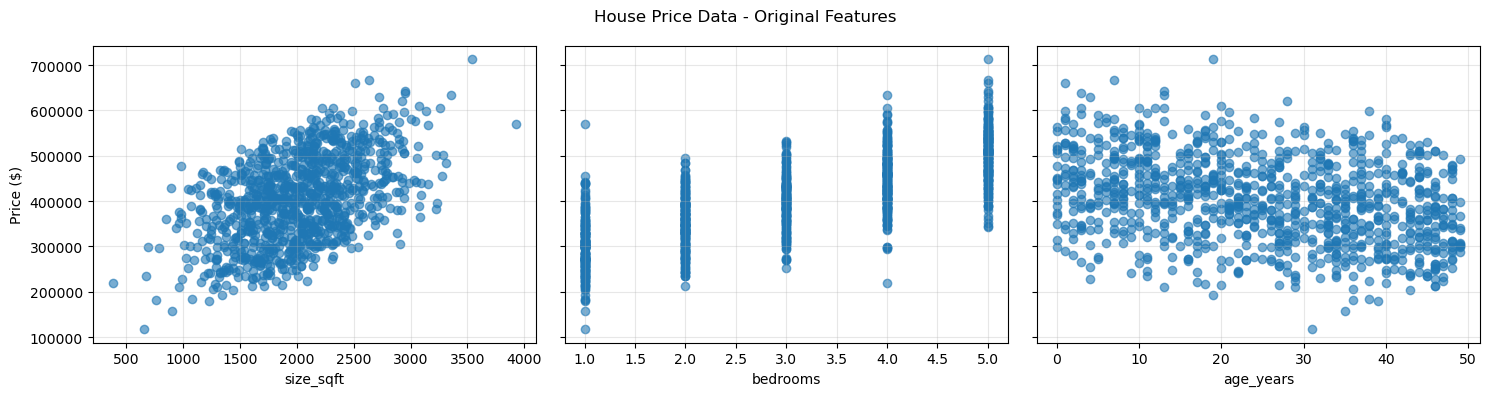

In [3]:
# Load the house prices dataset (same as multiple variable notebook)
training_dataset = pd.read_csv('/Users/olawalesalami/ML/aws-ml-bootcamp-2/StandFord Machine Learning/Data/house_prices.csv')

# Extract features and target
X_raw = training_dataset[['size_sqft', 'bedrooms', 'age_years']].values
y = training_dataset['price'].values

print(f"Dataset shape: {training_dataset.shape}")
print(f"Features shape: {X_raw.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFirst 5 rows:")
print(training_dataset.head())

# Visualize the original data
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
X_features = ['size_sqft', 'bedrooms', 'age_years']

for i in range(len(ax)):
    ax[i].scatter(X_raw[:, i], y, alpha=0.6)
    ax[i].set_xlabel(X_features[i])
    ax[i].grid(True, alpha=0.3)

ax[0].set_ylabel("Price ($)")
plt.suptitle('House Price Data - Original Features')
plt.tight_layout()
plt.show()

## Feature Engineering

We'll create polynomial features from the house price data to demonstrate overfitting and the benefits of regularization. This will create many features from our original 3 features.

In [4]:
def create_polynomial_features(X, degree):
    """
    Create polynomial features up to specified degree
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    return poly.fit_transform(X)

def normalize_features(X):
    """
    Normalize features using min-max normalization (same as multiple variable notebook)
    """
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    # Avoid division by zero
    X_range = X_max - X_min
    X_range = np.where(X_range == 0, 1, X_range)
    return (X - X_min) / X_range, X_min, X_range

# First normalize the original features (same as multiple variable notebook)
X_normalized, X_min, X_range = normalize_features(X_raw)

print(f"Original features after normalization:")
print(f"Size range: [{X_normalized[:, 0].min():.3f}, {X_normalized[:, 0].max():.3f}]")
print(f"Bedrooms range: [{X_normalized[:, 1].min():.3f}, {X_normalized[:, 1].max():.3f}]")
print(f"Age range: [{X_normalized[:, 2].min():.3f}, {X_normalized[:, 2].max():.3f}]")

# Create polynomial features (degree 8 to demonstrate overfitting without being too extreme)
degree = 8
X_poly = create_polynomial_features(X_normalized, degree)

print(f"\nFeature expansion:")
print(f"Original features: {X_raw.shape[1]}")
print(f"Polynomial features (degree {degree}): {X_poly.shape[1]}")
print(f"Feature expansion ratio: {X_poly.shape[1] / X_raw.shape[1]:.1f}x")

# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"\nData splits:")
print(f"Training set: {X_train.shape} ({X_train.shape[0]/len(y)*100:.0f}%)")
print(f"Validation set: {X_val.shape} ({X_val.shape[0]/len(y)*100:.0f}%)")
print(f"Test set: {X_test.shape} ({X_test.shape[0]/len(y)*100:.0f}%)")

Original features after normalization:
Size range: [0.000, 1.000]
Bedrooms range: [0.000, 1.000]
Age range: [0.000, 1.000]

Feature expansion:
Original features: 3
Polynomial features (degree 8): 164
Feature expansion ratio: 54.7x

Data splits:
Training set: (600, 164) (60%)
Validation set: (200, 164) (20%)
Test set: (200, 164) (20%)


## Regularized Linear Regression Implementation

### Base Class with Common Functionality

In [5]:
class RegularizedLinearRegression:
    """
    Base class for regularized linear regression
    """
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.train_cost_history = []
        self.val_cost_history = []
    
    def initialize_parameters(self, n_features):
        """Initialize weights and bias"""
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
    
    def predict(self, X):
        """Make predictions"""
        return np.dot(X, self.weights) + self.bias
    
    def compute_mse_cost(self, y_true, y_pred):
        """Compute Mean Squared Error"""
        return np.mean((y_true - y_pred) ** 2) / 2
    
    def compute_cost(self, X, y):
        """Compute total cost (MSE + regularization) - to be overridden"""
        y_pred = self.predict(X)
        return self.compute_mse_cost(y, y_pred)
    
    def compute_gradients(self, X, y):
        """Compute gradients - to be overridden"""
        m = len(y)
        y_pred = self.predict(X)
        
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        return dw, db
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """Train the model"""
        # Initialize parameters
        self.initialize_parameters(X_train.shape[1])
        
        # Training loop
        for i in range(self.max_iterations):
            # Compute gradients and update parameters
            dw, db = self.compute_gradients(X_train, y_train)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute costs
            train_cost = self.compute_cost(X_train, y_train)
            self.train_cost_history.append(train_cost)
            
            if X_val is not None and y_val is not None:
                val_cost = self.compute_cost(X_val, y_val)
                self.val_cost_history.append(val_cost)
            
            # Progress reporting
            if i % 100 == 0:
                if X_val is not None:
                    print(f"Iteration {i}: Train Cost = {train_cost:.6f}, Val Cost = {val_cost:.6f}")
                else:
                    print(f"Iteration {i}: Cost = {train_cost:.6f}")
            
            # Early stopping based on cost change
            if i > 0 and abs(self.train_cost_history[-2] - train_cost) < self.tolerance:
                print(f"Converged at iteration {i}")
                break
    
    def evaluate(self, X, y):
        """Evaluate model performance"""
        y_pred = self.predict(X)
        
        # R² Score
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        # MSE
        mse = np.mean((y - y_pred) ** 2)
        
        # RMSE
        rmse = np.sqrt(mse)
        
        return {'r2': r2, 'mse': mse, 'rmse': rmse}

print("✅ Base RegularizedLinearRegression class implemented")

✅ Base RegularizedLinearRegression class implemented


### Ridge Regression (L2 Regularization)

Ridge regression adds a penalty term proportional to the sum of squares of the weights:

$$\text{Penalty} = \lambda \sum_{j=1}^n w_j^2$$

**Gradient for Ridge:**
$$\frac{\partial J_{ridge}}{\partial w_j} = \frac{\partial J}{\partial w_j} + 2\lambda w_j$$

In [6]:
class RidgeRegression(RegularizedLinearRegression):
    """
    Ridge Regression (L2 Regularization)
    """
    def __init__(self, alpha=1.0, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        super().__init__(learning_rate, max_iterations, tolerance)
        self.alpha = alpha  # Regularization strength
    
    def compute_cost(self, X, y):
        """Compute cost with L2 regularization"""
        y_pred = self.predict(X)
        mse_cost = self.compute_mse_cost(y, y_pred)
        
        # L2 regularization term (don't regularize bias)
        l2_penalty = self.alpha * np.sum(self.weights ** 2)
        
        return mse_cost + l2_penalty
    
    def compute_gradients(self, X, y):
        """Compute gradients with L2 regularization"""
        m = len(y)
        y_pred = self.predict(X)
        
        # Standard gradients
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Add L2 regularization to weight gradients
        dw += 2 * self.alpha * self.weights
        
        return dw, db

print("✅ RidgeRegression class implemented")

✅ RidgeRegression class implemented


### Lasso Regression (L1 Regularization)

Lasso regression adds a penalty term proportional to the sum of absolute values of weights:

$$\text{Penalty} = \lambda \sum_{j=1}^n |w_j|$$

**Gradient for Lasso:**
$$\frac{\partial J_{lasso}}{\partial w_j} = \frac{\partial J}{\partial w_j} + \lambda \cdot \text{sign}(w_j)$$

In [7]:
class LassoRegression(RegularizedLinearRegression):
    """
    Lasso Regression (L1 Regularization)
    """
    def __init__(self, alpha=1.0, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        super().__init__(learning_rate, max_iterations, tolerance)
        self.alpha = alpha  # Regularization strength
    
    def compute_cost(self, X, y):
        """Compute cost with L1 regularization"""
        y_pred = self.predict(X)
        mse_cost = self.compute_mse_cost(y, y_pred)
        
        # L1 regularization term (don't regularize bias)
        l1_penalty = self.alpha * np.sum(np.abs(self.weights))
        
        return mse_cost + l1_penalty
    
    def compute_gradients(self, X, y):
        """Compute gradients with L1 regularization"""
        m = len(y)
        y_pred = self.predict(X)
        
        # Standard gradients
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Add L1 regularization to weight gradients
        # Use sign function, but handle zero weights carefully
        l1_gradient = np.where(self.weights > 0, 1, 
                              np.where(self.weights < 0, -1, 0))
        dw += self.alpha * l1_gradient
        
        return dw, db

print("✅ LassoRegression class implemented")

✅ LassoRegression class implemented


### Elastic Net Regression (L1 + L2)

Elastic Net combines both L1 and L2 regularization:

$$\text{Penalty} = \lambda_1 \sum_{j=1}^n |w_j| + \lambda_2 \sum_{j=1}^n w_j^2$$

In [8]:
class ElasticNetRegression(RegularizedLinearRegression):
    """
    Elastic Net Regression (L1 + L2 Regularization)
    """
    def __init__(self, alpha=1.0, l1_ratio=0.5, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        super().__init__(learning_rate, max_iterations, tolerance)
        self.alpha = alpha  # Total regularization strength
        self.l1_ratio = l1_ratio  # Ratio of L1 to total regularization (0=Ridge, 1=Lasso)
        
        # Split alpha between L1 and L2
        self.alpha_l1 = alpha * l1_ratio
        self.alpha_l2 = alpha * (1 - l1_ratio)
    
    def compute_cost(self, X, y):
        """Compute cost with L1 + L2 regularization"""
        y_pred = self.predict(X)
        mse_cost = self.compute_mse_cost(y, y_pred)
        
        # L1 and L2 regularization terms
        l1_penalty = self.alpha_l1 * np.sum(np.abs(self.weights))
        l2_penalty = self.alpha_l2 * np.sum(self.weights ** 2)
        
        return mse_cost + l1_penalty + l2_penalty
    
    def compute_gradients(self, X, y):
        """Compute gradients with L1 + L2 regularization"""
        m = len(y)
        y_pred = self.predict(X)
        
        # Standard gradients
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Add L1 regularization
        l1_gradient = np.where(self.weights > 0, 1, 
                              np.where(self.weights < 0, -1, 0))
        dw += self.alpha_l1 * l1_gradient
        
        # Add L2 regularization
        dw += 2 * self.alpha_l2 * self.weights
        
        return dw, db

print("✅ ElasticNetRegression class implemented")

✅ ElasticNetRegression class implemented


## Training and Comparison

Let's train all models and compare their performance:

In [11]:
# Define models to compare
models = {
    'Linear (No Regularization)': RegularizedLinearRegression(learning_rate=0.01, max_iterations=2000),
    'Ridge (α=0.1)': RidgeRegression(alpha=0.1, learning_rate=0.01, max_iterations=2000),
    'Ridge (α=1.0)': RidgeRegression(alpha=1.0, learning_rate=0.01, max_iterations=2000),
    'Lasso (α=0.01)': LassoRegression(alpha=0.01, learning_rate=0.01, max_iterations=2000),
    'Lasso (α=0.1)': LassoRegression(alpha=0.1, learning_rate=0.01, max_iterations=2000),
    'Elastic Net (α=0.1)': ElasticNetRegression(alpha=0.1, l1_ratio=0.5, learning_rate=0.01, max_iterations=2000)
}

# Train all models
trained_models = {}
results = {}

print("🚀 Training all models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    print("-" * 50)
    
    # Train model
    model.fit(X_train, y_train, X_val, y_val)
    
    # Evaluate on training and validation sets
    train_metrics = model.evaluate(X_train, y_train)
    val_metrics = model.evaluate(X_val, y_val)
    test_metrics = model.evaluate(X_test, y_test)
    
    # Store results
    trained_models[name] = model
    results[name] = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'weights_norm': np.linalg.norm(model.weights),
        'non_zero_weights': np.sum(np.abs(model.weights) > 1e-6)
    }
    
    print(f"Train R²: {train_metrics['r2']:.4f}, Val R²: {val_metrics['r2']:.4f}, Test R²: {test_metrics['r2']:.4f}")
    print(f"Weights norm: {results[name]['weights_norm']:.4f}")
    print(f"Non-zero weights: {results[name]['non_zero_weights']}/{len(model.weights)}\n")

print("✅ All models trained!")

🚀 Training all models...

Training Linear (No Regularization)...
--------------------------------------------------
Iteration 0: Train Cost = 79232443977.097244, Val Cost = 77822428112.661667
Iteration 100: Train Cost = 6071909689.534903, Val Cost = 5723792787.194888
Iteration 200: Train Cost = 2535177985.121895, Val Cost = 2357915404.149164
Iteration 300: Train Cost = 1516135121.091187, Val Cost = 1361895329.169325
Iteration 400: Train Cost = 1155209119.713532, Val Cost = 1006982217.087051
Iteration 500: Train Cost = 983955285.764754, Val Cost = 844955222.681092
Iteration 600: Train Cost = 877662510.539073, Val Cost = 750107801.213577
Iteration 700: Train Cost = 800287121.320211, Val Cost = 684278368.045178
Iteration 800: Train Cost = 739625850.053215, Val Cost = 634248554.417466
Iteration 900: Train Cost = 690393093.550456, Val Cost = 594453240.340252
Iteration 1000: Train Cost = 649643165.783789, Val Cost = 561986600.612243
Iteration 1100: Train Cost = 615435878.939974, Val Cost = 5

## Results Analysis and Visualization

In [12]:
# Create comprehensive results table
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[name]['train']['r2'] for name in results.keys()],
    'Val R²': [results[name]['val']['r2'] for name in results.keys()],
    'Test R²': [results[name]['test']['r2'] for name in results.keys()],
    'Train RMSE': [results[name]['train']['rmse'] for name in results.keys()],
    'Val RMSE': [results[name]['val']['rmse'] for name in results.keys()],
    'Test RMSE': [results[name]['test']['rmse'] for name in results.keys()],
    'Weights Norm': [results[name]['weights_norm'] for name in results.keys()],
    'Non-zero Weights': [results[name]['non_zero_weights'] for name in results.keys()]
})

# Calculate overfitting (difference between train and validation performance)
results_df['Overfitting (Train-Val R²)'] = results_df['Train R²'] - results_df['Val R²']

print("📊 Model Comparison Results:")
print("=" * 80)
print(results_df.round(4).to_string(index=False))

# Find best model based on validation performance
best_model_name = results_df.loc[results_df['Val R²'].idxmax(), 'Model']
print(f"\n🏆 Best model based on validation R²: {best_model_name}")

📊 Model Comparison Results:
                     Model  Train R²  Val R²  Test R²  Train RMSE   Val RMSE  Test RMSE  Weights Norm  Non-zero Weights  Overfitting (Train-Val R²)
Linear (No Regularization)    0.9003  0.8955   0.9070  30157.3592 28764.3406 29281.0246   210970.8831               164                      0.0048
             Ridge (α=0.1)    0.7556  0.7143   0.7467  47205.6253 47566.7545 48337.4060    81355.4747               164                      0.0414
             Ridge (α=1.0)    0.4194  0.3783   0.4135  72764.5733 70167.7307 73550.1221    26287.4603               164                      0.0411
            Lasso (α=0.01)    0.9003  0.8955   0.9070  30157.3306 28764.3220 29281.0167   210970.7065               164                      0.0048
             Lasso (α=0.1)    0.9003  0.8955   0.9070  30157.0602 28764.1451 29280.9379   210969.1457               164                      0.0048
       Elastic Net (α=0.1)    0.8245  0.8005   0.8182  40001.5888 39750.7620 40948.6

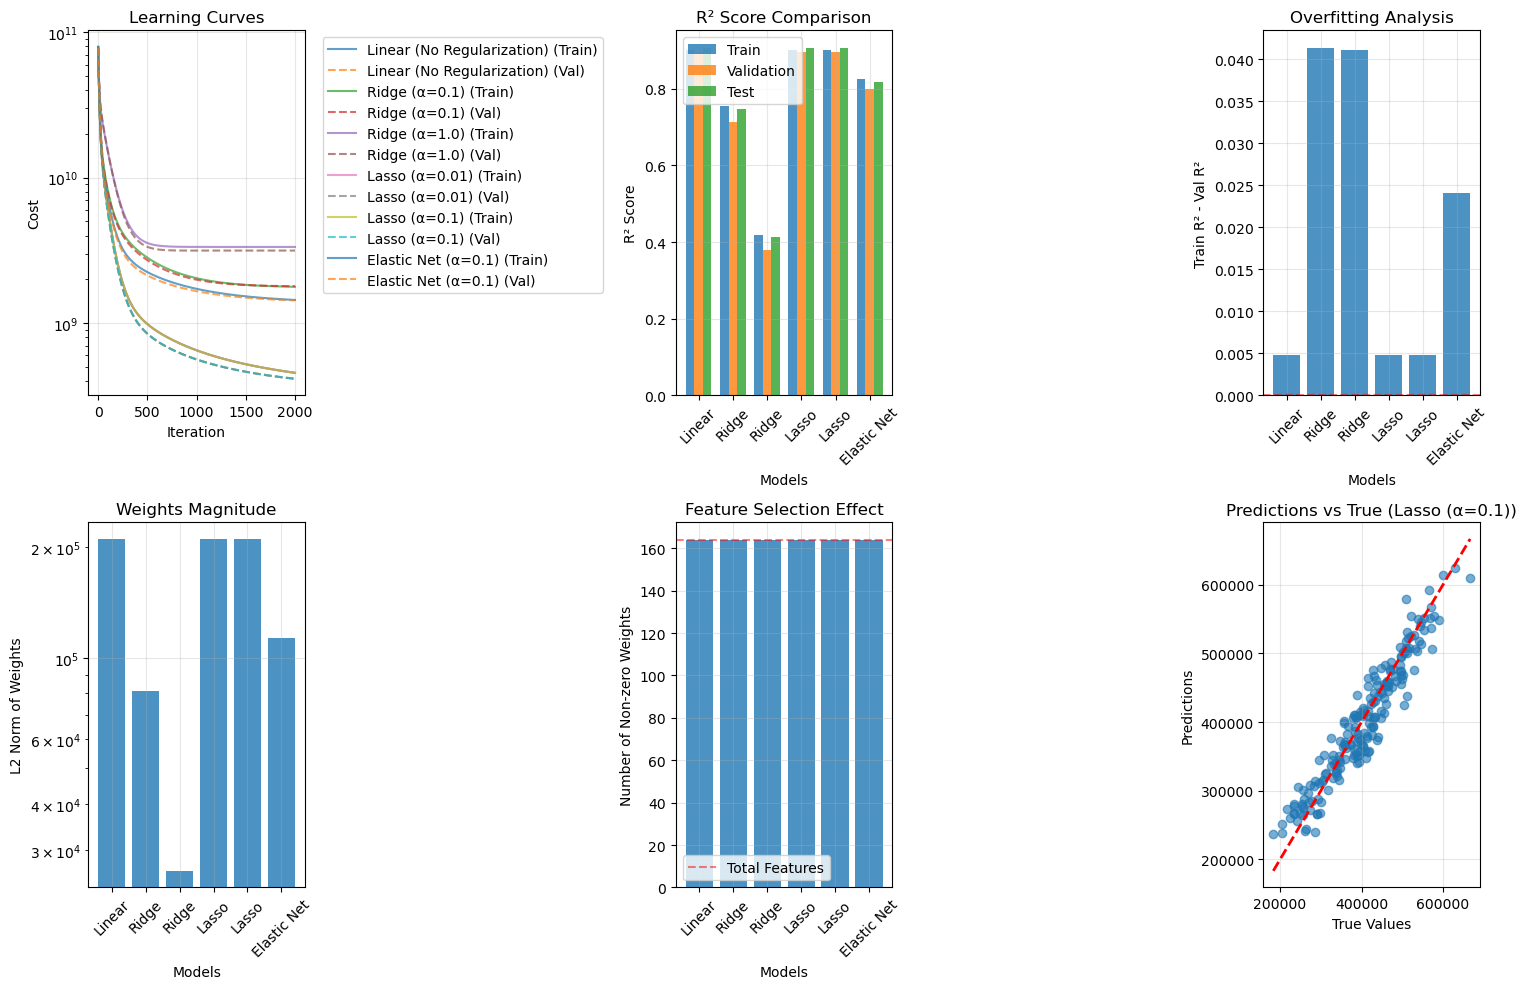

In [14]:
# Visualization: Learning curves
plt.figure(figsize=(15, 10))

# Plot 1: Training and Validation Loss Curves
plt.subplot(2, 3, 1)
for name, model in trained_models.items():
    if len(model.val_cost_history) > 0:
        plt.plot(model.train_cost_history, label=f'{name} (Train)', alpha=0.7)
        plt.plot(model.val_cost_history, label=f'{name} (Val)', linestyle='--', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Learning Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: R² Scores Comparison
plt.subplot(2, 3, 2)
x_pos = np.arange(len(results_df))
width = 0.25

plt.bar(x_pos - width, results_df['Train R²'], width, label='Train', alpha=0.8)
plt.bar(x_pos, results_df['Val R²'], width, label='Validation', alpha=0.8)
plt.bar(x_pos + width, results_df['Test R²'], width, label='Test', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(x_pos, [name.split('(')[0].strip() for name in results_df['Model']], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Overfitting Analysis
plt.subplot(2, 3, 3)
plt.bar(range(len(results_df)), results_df['Overfitting (Train-Val R²)'], alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Train R² - Val R²')
plt.title('Overfitting Analysis')
plt.xticks(range(len(results_df)), [name.split('(')[0].strip() for name in results_df['Model']], rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 4: Weights Magnitude
plt.subplot(2, 3, 4)
plt.bar(range(len(results_df)), results_df['Weights Norm'], alpha=0.8)
plt.xlabel('Models')
plt.ylabel('L2 Norm of Weights')
plt.title('Weights Magnitude')
plt.xticks(range(len(results_df)), [name.split('(')[0].strip() for name in results_df['Model']], rotation=45)
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 5: Feature Selection (Non-zero weights)
plt.subplot(2, 3, 5)
plt.bar(range(len(results_df)), results_df['Non-zero Weights'], alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Number of Non-zero Weights')
plt.title('Feature Selection Effect')
plt.xticks(range(len(results_df)), [name.split('(')[0].strip() for name in results_df['Model']], rotation=45)
plt.axhline(y=X_train.shape[1], color='red', linestyle='--', alpha=0.5, label='Total Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Predictions vs True Values (Best Model)
plt.subplot(2, 3, 6)
best_model = trained_models[best_model_name]
y_pred_test = best_model.predict(X_test)

plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True ({best_model_name})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Regularization Path Analysis

Let's analyze how different regularization strengths affect the model:

In [15]:
def analyze_regularization_path(RegularizationClass, alphas, model_name):
    """
    Analyze how regularization strength affects model performance
    """
    results = []
    
    for alpha in alphas:
        # Train model
        model = RegularizationClass(alpha=alpha, learning_rate=0.01, max_iterations=2000)
        model.fit(X_train, y_train, X_val, y_val)
        
        # Evaluate
        train_metrics = model.evaluate(X_train, y_train)
        val_metrics = model.evaluate(X_val, y_val)
        
        results.append({
            'alpha': alpha,
            'train_r2': train_metrics['r2'],
            'val_r2': val_metrics['r2'],
            'weights_norm': np.linalg.norm(model.weights),
            'non_zero_weights': np.sum(np.abs(model.weights) > 1e-6)
        })
    
    return pd.DataFrame(results)

# Define alpha ranges
alphas_ridge = np.logspace(-4, 2, 20)  # 0.0001 to 100
alphas_lasso = np.logspace(-4, 0, 20)  # 0.0001 to 1

print("🔍 Analyzing regularization paths...")

# Analyze Ridge regularization path
ridge_path = analyze_regularization_path(RidgeRegression, alphas_ridge, 'Ridge')

# Analyze Lasso regularization path
lasso_path = analyze_regularization_path(LassoRegression, alphas_lasso, 'Lasso')

print("✅ Regularization path analysis completed!")

🔍 Analyzing regularization paths...
Iteration 0: Train Cost = 79232447153.908920, Val Cost = 77822431998.364548
Iteration 100: Train Cost = 6074197393.142977, Val Cost = 5726193249.785288
Iteration 200: Train Cost = 2538178645.400622, Val Cost = 2360946820.660371
Iteration 300: Train Cost = 1519508975.479373, Val Cost = 1365302908.024492
Iteration 400: Train Cost = 1158746788.638393, Val Cost = 1010573597.706116
Iteration 500: Train Cost = 987584423.621913, Val Cost = 848651786.719218
Iteration 600: Train Cost = 881367488.092585, Val Cost = 753885239.374358
Iteration 700: Train Cost = 804068970.089751, Val Cost = 688131590.359334
Iteration 800: Train Cost = 743488198.516631, Val Cost = 638177711.633530
Iteration 900: Train Cost = 694338442.938256, Val Cost = 598459138.384423
Iteration 1000: Train Cost = 653672457.314211, Val Cost = 566069517.061149
Iteration 1100: Train Cost = 619548857.659505, Val Cost = 539210619.438849
Iteration 1200: Train Cost = 590578797.581737, Val Cost = 516649

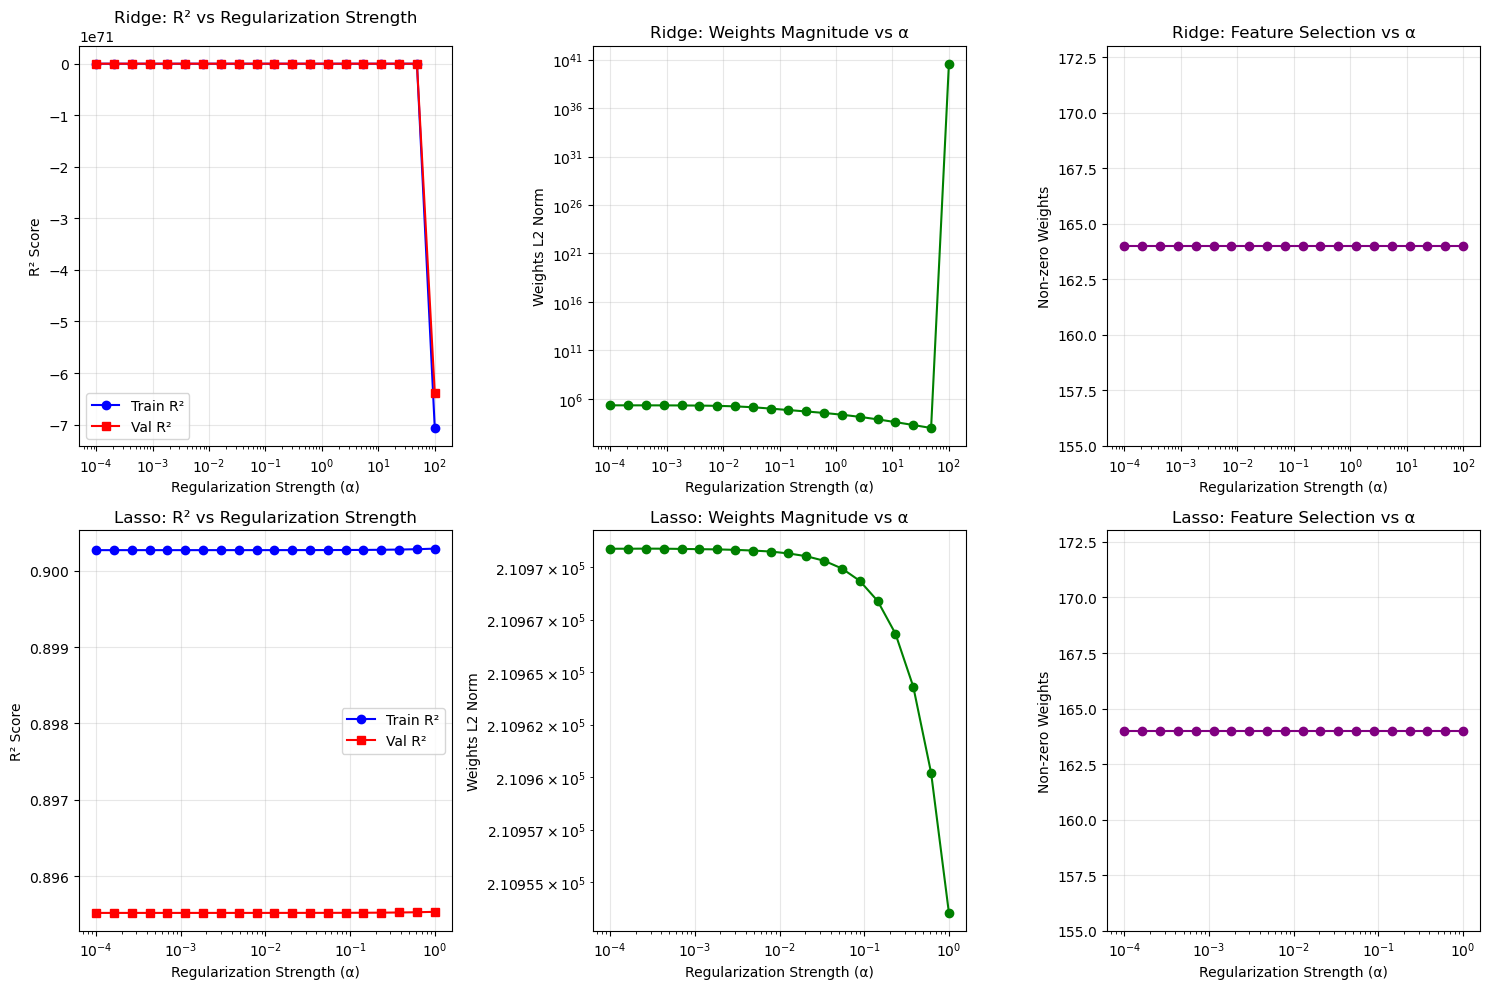

🎯 Optimal Ridge α: 0.000100
🎯 Optimal Lasso α: 1.000000


In [16]:
# Visualize regularization paths
plt.figure(figsize=(15, 10))

# Ridge Regularization Path
plt.subplot(2, 3, 1)
plt.semilogx(ridge_path['alpha'], ridge_path['train_r2'], 'b-', label='Train R²', marker='o')
plt.semilogx(ridge_path['alpha'], ridge_path['val_r2'], 'r-', label='Val R²', marker='s')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('R² Score')
plt.title('Ridge: R² vs Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.loglog(ridge_path['alpha'], ridge_path['weights_norm'], 'g-', marker='o')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('Weights L2 Norm')
plt.title('Ridge: Weights Magnitude vs α')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.semilogx(ridge_path['alpha'], ridge_path['non_zero_weights'], 'purple', marker='o')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('Non-zero Weights')
plt.title('Ridge: Feature Selection vs α')
plt.grid(True, alpha=0.3)

# Lasso Regularization Path
plt.subplot(2, 3, 4)
plt.semilogx(lasso_path['alpha'], lasso_path['train_r2'], 'b-', label='Train R²', marker='o')
plt.semilogx(lasso_path['alpha'], lasso_path['val_r2'], 'r-', label='Val R²', marker='s')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('R² Score')
plt.title('Lasso: R² vs Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.loglog(lasso_path['alpha'], lasso_path['weights_norm'], 'g-', marker='o')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('Weights L2 Norm')
plt.title('Lasso: Weights Magnitude vs α')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.semilogx(lasso_path['alpha'], lasso_path['non_zero_weights'], 'purple', marker='o')
plt.xlabel('Regularization Strength (α)')
plt.ylabel('Non-zero Weights')
plt.title('Lasso: Feature Selection vs α')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal alpha values
optimal_ridge_alpha = ridge_path.loc[ridge_path['val_r2'].idxmax(), 'alpha']
optimal_lasso_alpha = lasso_path.loc[lasso_path['val_r2'].idxmax(), 'alpha']

print(f"🎯 Optimal Ridge α: {optimal_ridge_alpha:.6f}")
print(f"🎯 Optimal Lasso α: {optimal_lasso_alpha:.6f}")

## Key Insights and Conclusions

### Regularization Effects:

1. **Ridge Regression (L2)**:
   - Shrinks weights towards zero but doesn't eliminate them
   - Helps with multicollinearity
   - Reduces overfitting by penalizing large weights

2. **Lasso Regression (L1)**:
   - Can set weights exactly to zero (feature selection)
   - Produces sparse models
   - Useful when you have many irrelevant features

3. **Elastic Net**:
   - Combines benefits of both Ridge and Lasso
   - Good balance between feature selection and weight shrinkage

### When to Use Each:
- **Ridge**: When you believe most features are relevant
- **Lasso**: When you want automatic feature selection
- **Elastic Net**: When you want both feature selection and handling of correlated features

In [17]:
# Final summary
print("📋 REGULARIZATION SUMMARY")
print("=" * 50)
print(f"Dataset: House prices with {X_train.shape[0]} training samples, {X_train.shape[1]} polynomial features")
print(f"Best performing model: {best_model_name}")
print(f"Best validation R²: {results_df['Val R²'].max():.4f}")
print(f"Optimal Ridge α: {optimal_ridge_alpha:.6f}")
print(f"Optimal Lasso α: {optimal_lasso_alpha:.6f}")

print("\n🎓 Key Learnings:")
print("• Regularization helps prevent overfitting in high-dimensional data")
print("• L1 (Lasso) provides automatic feature selection")
print("• L2 (Ridge) shrinks weights but keeps all features")
print("• Elastic Net combines benefits of both L1 and L2")
print("• Cross-validation is crucial for selecting optimal regularization strength")

📋 REGULARIZATION SUMMARY
Dataset: House prices with 600 training samples, 164 polynomial features
Best performing model: Lasso (α=0.1)
Best validation R²: 0.8955
Optimal Ridge α: 0.000100
Optimal Lasso α: 1.000000

🎓 Key Learnings:
• Regularization helps prevent overfitting in high-dimensional data
• L1 (Lasso) provides automatic feature selection
• L2 (Ridge) shrinks weights but keeps all features
• Elastic Net combines benefits of both L1 and L2
• Cross-validation is crucial for selecting optimal regularization strength
